In [201]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [202]:
%pip install yfinance
%pip install matplotlib
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [203]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [204]:
forex_list = [
    'EURUSD=X',  # Euro / US Dollar
    'GBPUSD=X',  # British Pound / US Dollar
    'USDJPY=X',  # US Dollar / Japanese Yen
    'AUDUSD=X',  # Australian Dollar / US Dollar
    'NZDUSD=X',  # New Zealand Dollar / US Dollar
    'USDCAD=X',  # US Dollar / Canadian Dollar
    'USDCHF=X',  # US Dollar / Swiss Franc
    'EURGBP=X',  # Euro / British Pound
    'EURJPY=X',  # Euro / Japanese Yen
    'GBPJPY=X',  # British Pound / Japanese Yen
    'AUDJPY=X',  # Australian Dollar / Japanese Yen
    'EURAUD=X',  # Euro / Australian Dollar
    'EURCAD=X',  # Euro / Canadian Dollar
    'AUDCAD=X',  # Australian Dollar / Canadian Dollar
    'GBPCHF=X',  # British Pound / Swiss Franc
    'EURCHF=X',  # Euro / Swiss Franc
    'NZDJPY=X',  # New Zealand Dollar / Japanese Yen
    'GBPCAD=X',  # British Pound / Canadian Dollar
    'CHFJPY=X',  # Swiss Franc / Japanese Yen
    'CADJPY=X',  # Canadian Dollar / Japanese Yen
    'AUDNZD=X',  # Australian Dollar / New Zealand Dollar
    'EURNZD=X',  # Euro / New Zealand Dollar
    'USDHKD=X',  # US Dollar / Hong Kong Dollar
    'USDSGD=X',  # US Dollar / Singapore Dollar
    'USDZAR=X'   # US Dollar / South African Rand
]

In [205]:
# Dictionary to hold: 
#                    [Forex Ticker String] ---> [Forex Ticker Financial Info]
forex_pandas_dict = {}

# Grabs the financial info for each ticker and adds the DF to the dict of df's
for i in range(0,len(forex_list)):
    forex_data = yf.download(forex_list[i], start='2001-01-01', end='2024-01-01')

    forex_data.index = pd.to_datetime(forex_data.index)
    forex_pandas_dict[forex_list[i]] = forex_data

# Check one of the tickers to see if it worked correctly
print(forex_pandas_dict['EURUSD=X'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2003-12-01  1.203398  1.204007  1.194401  1.196501   1.196501       0
2003-12-02  1.196101  1.210903  1.194600  1.208897   1.208897       0
2003-12-03  1.209000  1.213003  1.207700  1.212298   1.212298       0
2003-12-04  1.212004  1.214403  1.204398  1.208094   1.208094       0
2003-12-05  1.207802  1.219096  1.206593  1.218695   1.218695       0
...              ...       ...       ...       ...        ...     ...
2023-12-25  1.102657  1.104240  1.099989  1.102657   1.102657       0
2023-12-26  1.102026  1.103997  1.100958  1.102026   1.102026       0
2023-12-27  1.104301  1.112248  1.102925  1.104301   1.104301       0
2023-12-28  1.110864  1.113945  1.107101  1.110864   1.110864       0
2023-12-29  1.106819  1.108647  1.104326  1.106819   1.106819       0

[5211 rows x 6 columns]


In [206]:
# # # Can be used to see what dates are present in all the DFs and cut them all down to only those dates,
# # #  so we can run cointegration and other sort of tests
# # # Unfurtunately, this cuts a lot of data (for example the EURUSD=X goes from 4168 rows to 3520) 

# # # Another option, that will be done latter, does the same but only for the two dataframes we are comparing 
# # # in the moment.

# # # I choose the second oprion, but I will let this here in case someone prefers this.



# def filter_dates(forex_pandas_dict):
#     #get all the common dates between DFs
#     common_dates = set(forex_pandas_dict[next(iter(forex_pandas_dict))].index)  # start with the index of the first DataFrame
#     for df in forex_pandas_dict.values():
#         common_dates = common_dates.intersection(set(df.index))  # update intersection with the next DataFrame's index

#     #keep only the rows in each DF that bellong to the common dates
#     common_dates = sorted(common_dates)  # sort the dates to maintain order
#     filtered_dict = {name: df.loc[common_dates] for name, df in forex_pandas_dict.items()}

#     return filtered_dict

# forex_pandas_dict=filter_dates_in_all_dfs(forex_pandas_dict)

In [207]:
# Can be used to see what dates are present in two DFs being compared

def filter_dates(forex_pandas_dict, df_1, df_2):
    
    #get all the common dates between DFs
    common_dates = forex_pandas_dict[df_1].index.intersection(forex_pandas_dict[df_2].index)

    #keep only the rows in each DF that bellong to the common dates
    df1_filtered = forex_pandas_dict[df_1].loc[common_dates]
    df2_filtered = forex_pandas_dict[df_2].loc[common_dates]

    return df1_filtered, df2_filtered


In [208]:
print(len(forex1))
print(len(forex2))

5221
5221


In [209]:
coint_results_df = pd.DataFrame(columns=['coint_stat', 'p_value', 'critical_values'])

for ticker_one in forex_list:
    for ticker_two in forex_list:
        if (ticker_one != ticker_two) and (ticker_two[:-2] +'/'+ticker_one[:-2]) not in coint_results_df.index:

            filter_df1, filter_df2 = filter_dates(forex_pandas_dict, ticker_one, ticker_two)
            forex1 = filter_df1['Close']
            forex2 = filter_df2['Close']
            # Perform the cointegration test
            coint_test = coint(forex1, forex2)

            # Get the results
            coint_stat, p_value, critical_values = coint_test

            index = ticker_one[:-2] +'/'+ticker_two[:-2]
            values = [coint_stat, p_value, critical_values]
            coint_results_df.loc[index] = values

In [210]:
coint_results_copy = coint_results_df.copy()
coint_results_copy.sort_values(by='p_value').head()

,coint_stat,p_value,critical_values
AUDUSD/USDCAD,-4.527765,0.001102,"[-3.898829710145727, -3.337462661968801, -3.04..."
EURCAD/USDSGD,-3.889933,0.010241,"[-3.8985453489541664, -3.337304142335244, -3.0..."
USDCHF/GBPCHF,-3.837170,0.012085,"[-3.898521342431384, -3.3372907589584857, -3.0..."
EURAUD/AUDCAD,-3.825267,0.012540,"[-3.8985364825321454, -3.337299199414132, -3.0..."
USDCHF/GBPCAD,-3.790126,0.013972,"[-3.8985384910641585, -3.33730031914736, -3.04..."


In [211]:
average = coint_results_df['coint_stat'].mean()   # Average
maximum = coint_results_df['coint_stat'].max()    # Maximum
minimum = coint_results_df['coint_stat'].min()    # Minimum
print(f'Average: {average}, Maximum: {maximum}, Minimum: {minimum}')

Average: -2.277373583956266, Maximum: 0.6613118273927425, Minimum: -4.52776490714311


## What we are looking for:
- Pairs that offer the lowest p-value, because this helps us understand if we should reject the null hypothesis in the coint statistical test we are trying to preform. We will use common thresholds of preferring bellow 0.01 and rejecting everything above 0.05
- Pairs that offer the most negative coint_stat 
- Pairs that offer a coint_stat value lower (more negative) than the 1% critical_value

In [212]:
def get_cointegrated_pairs(coint_results, p_value_threshold=0.01):
    # Remove all rows with p_values above 0.01
    coint_results = coint_results[coint_results['p_value'] <= p_value_threshold]
    
    # Remove all rows with coint_stat below the 1% critical value
    coint_results = coint_results[coint_results['coint_stat'] < coint_results['critical_values'].apply(lambda x: x[0])]

    return coint_results

In [213]:
coint_final_pairs = get_cointegrated_pairs(coint_results_copy, p_value_threshold=0.01)
coint_final_pairs

,coint_stat,p_value,critical_values
AUDUSD/USDCAD,-4.527765,0.001102,"[-3.898829710145727, -3.337462661968801, -3.04..."


## Strategy in Backtrader

In [214]:
%pip install backtrader

Note: you may need to restart the kernel to use updated packages.


In [215]:
import backtrader as bt

In [216]:
# Get the best pair tickers and return to the original format so we can grab their info from the dict
pair_tickers = coint_final_pairs.index[0]
ticker_one = pair_tickers.split('/')[0] + '=X'
ticker_two = pair_tickers.split('/')[1] + '=X'
print(ticker_one, ticker_two)

AUDUSD=X USDCAD=X


In [217]:
# Grab the tickers info from the dict
ticker_one_df, ticker_two_df = filter_dates(forex_pandas_dict, ticker_one, ticker_two)

In [218]:
def plot_close_prices(ticker_one_df, ticker_two_df):    
    # Plot the 'Close' column of both dataframes
    plt.figure(figsize=(10, 6))

    plt.plot(ticker_one_df.index, ticker_one_df['Close'], label='Stock 1 Close Price', color='blue')
    plt.plot(ticker_two_df.index, ticker_two_df['Close'], label='Stock 2 Close Price', color='green')

    # Add title and labels
    plt.title('Close Prices of Stock 1 and Stock 2')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Display the legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

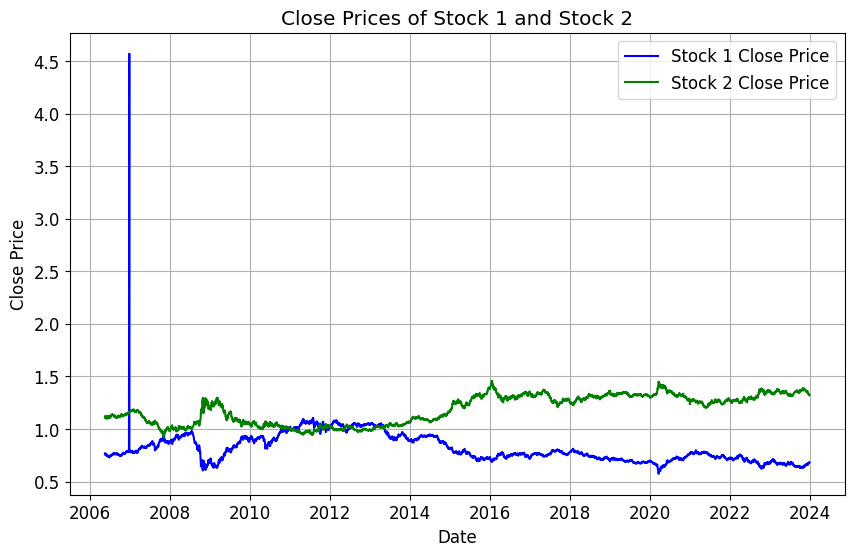

In [219]:
plot_close_prices(ticker_one_df, ticker_two_df)

In [220]:
# Lets remove that weird outlier
max_id = ticker_one_df['Close'].idxmax()

ticker_one_df = ticker_one_df.drop(max_id)
ticker_two_df = ticker_two_df.drop(max_id)

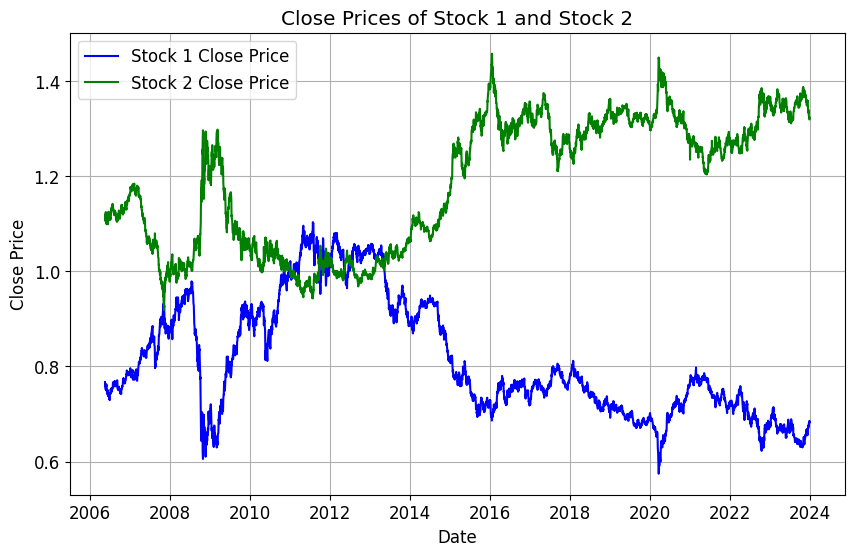

In [221]:
# Now lets plot again
plot_close_prices(ticker_one_df, ticker_two_df)

In [222]:
# Backtrader strategy: Statistical arbitrage
#   - We are going to use the z-score to determine when to buy and sell the two assets
#   - If the z-score is above 2, we will short the higher priced asset and long the lower priced asset
#   - If the z-score is below -2, we will long the higher priced asset and short the lower priced asset
#   - If the z-score is between -0.5 and 0.5, we will close all positions

class StatsArbitrageForexPairs(bt.Strategy):

    params = (
        ('risk_per_trade', 0.01),  # Risk 1% of equity per trade
    )
        
    def __init__(self):
        self.order = None
        self.dataclose1 = self.datas[0].close
        self.dataclose2 = self.datas[1].close
        self.differences = []
        self.window_size = 30  # Rolling window size for mean/std deviation
        self.z_score_upper_threshold = 2
        self.z_score_lower_threshold = -2

    def next(self):
        # Get the current price of the two assets
        t_one_curre_price = self.dataclose1[0]
        t_two_curr_price = self.dataclose2[0]

        # Calculate the difference between the two assets
        curr_diff = t_one_curre_price - t_two_curr_price
        self.differences.append(curr_diff)

        # Maintain a rolling window
        if len(self.differences) > self.window_size:
            self.differences.pop(0)

        # Calculate the elements needed to calc the z-score
        if len(self.differences) > 1:
            mean_diff = np.mean(self.differences)
            std_diff = np.std(self.differences)
            z_score = (curr_diff - mean_diff) / std_diff if std_diff != 0 else 0

            # Get account value
            account_value = self.broker.getvalue()
            risk_amount = account_value * self.params.risk_per_trade 
            t_one_position_size = risk_amount / t_one_curre_price
            t_two_position_size = risk_amount / t_two_curr_price

            if not self.position:
                if z_score > self.z_score_upper_threshold:
                    if t_one_curre_price> t_two_curr_price:
                        self.sell(data=self.datas[0], size = t_one_position_size)#short highest price asset
                        self.buy(data=self.datas[1], size = t_two_position_size)#long lowest priced asset
                    else:
                        self.sell(data=self.datas[1], size = t_two_position_size)#short highest price asset
                        self.buy(data=self.datas[0], size = t_one_position_size)#long lowest priced asset
                elif z_score < self.z_score_lower_threshold:
                    if t_one_curre_price> t_two_curr_price:
                        self.buy(data=self.datas[0], size = t_one_position_size)#long highest price asset
                        self.sell(data=self.datas[1], size = t_two_position_size)#short lowest priced asset
                    else:
                        self.buy(data=self.datas[1], size = t_two_position_size)#long highest price asset
                        self.sell(data=self.datas[0], size = t_one_position_size)#short lowest priced asset
            elif abs(z_score) < 0.5:
                # Close all positions
                self.close(data=self.datas[0])
                self.close(data=self.datas[1])

In [223]:
# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Set the initial capital
cerebro.broker.setcash(100000.0)

# Add the two data feeds
ticker_data1 = bt.feeds.PandasData(dataname=ticker_one_df)
ticker_data2 = bt.feeds.PandasData(dataname=ticker_two_df)

# Add the data feeds to cerebro
cerebro.adddata(ticker_data1)
cerebro.adddata(ticker_data2)

# Add the strategy to cerebro
cerebro.addstrategy(StatsArbitrageForexPairs)

initial_portfolio_value = cerebro.broker.getvalue()

# Run the backtest
cerebro.run()

final_portfolio_value = cerebro.broker.getvalue()


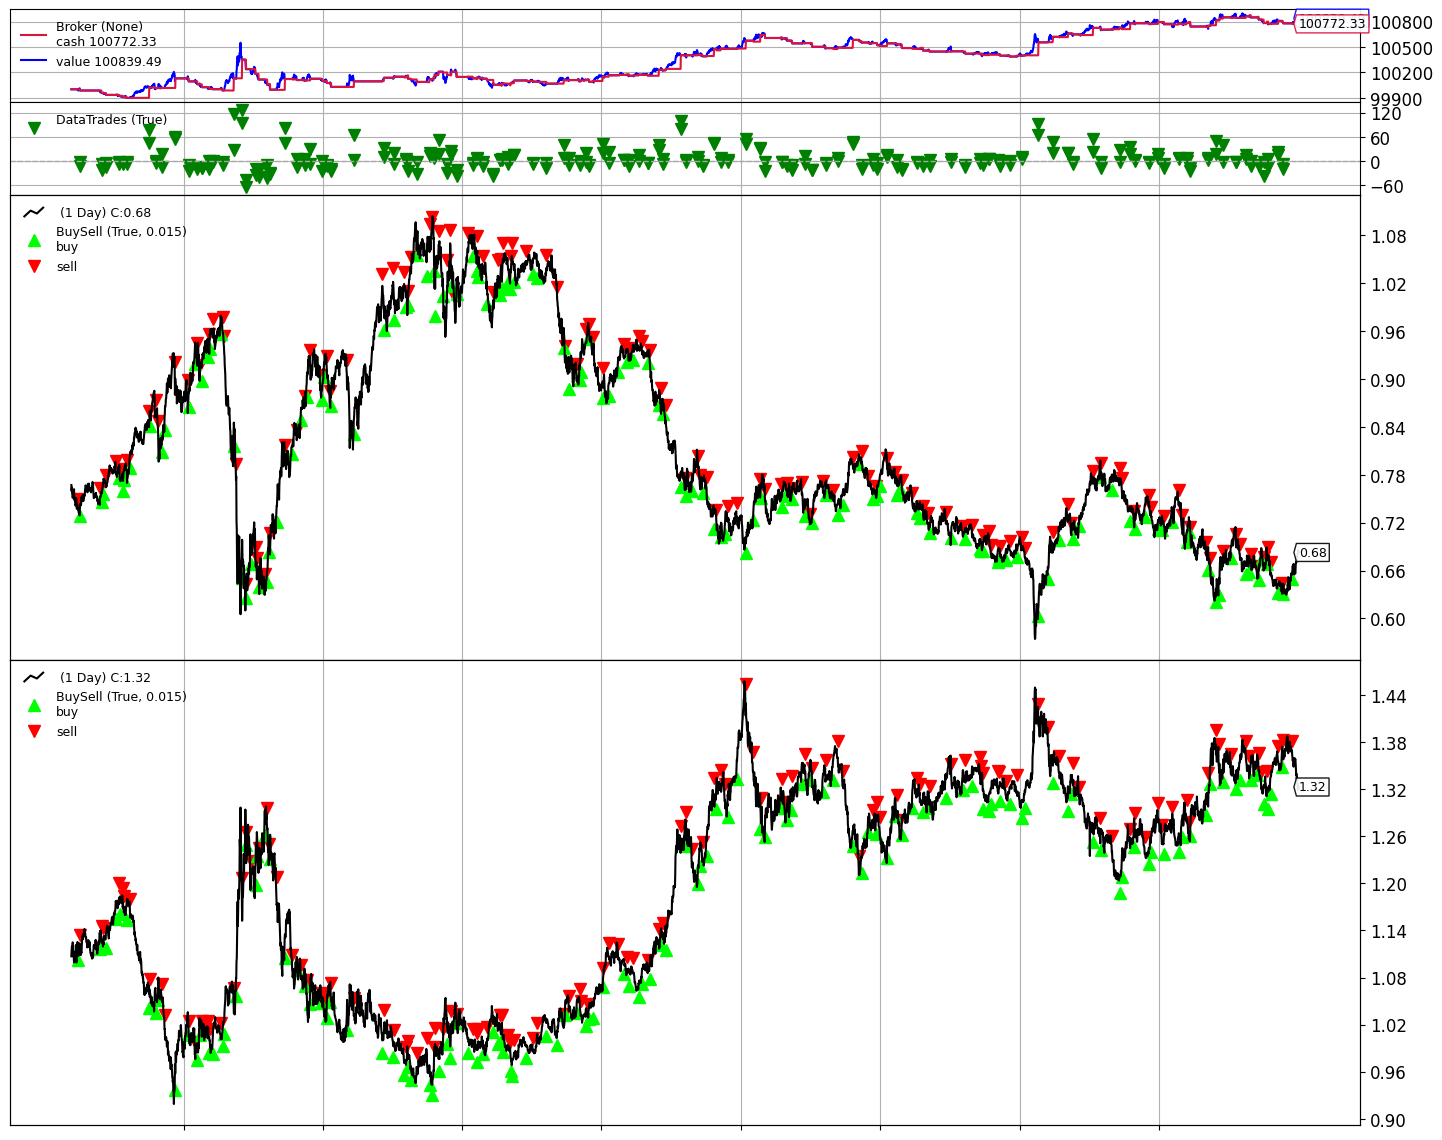

[[<Figure size 1500x1200 with 6 Axes>]]

In [224]:
# Plot the results
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)

In [225]:
print(f'Starting Portfolio Value: {initial_portfolio_value:.2f}')
print(f'Ending Portfolio Value: {final_portfolio_value:.2f}')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100839.49


## Second Strategy in Bactrader
What if we base the position size on how deviated from the z_threshold the assets are?

In [226]:
# Backtrader strategy: Statistical arbitrage
#   - We are going to use the z-score to determine when to buy and sell the two assets
#   - If the z-score is above 2, we will short the higher priced asset and long the lower priced asset
#   - If the z-score is below -2, we will long the higher priced asset and short the lower priced asset
#   - If the z-score is between -0.5 and 0.5, we will close all positions

class StatsArbitrageForexPairsTwo(bt.Strategy):

    params = (
        ('risk_per_trade', 0.01),  # Risk 1% of equity per trade
    )
        
    def __init__(self):
        self.order = None
        self.dataclose1 = self.datas[0].close
        self.dataclose2 = self.datas[1].close
        self.differences = []
        self.window_size = 30  # Rolling window size for mean/std deviation
        self.z_score_upper_threshold = 2
        self.z_score_lower_threshold = -2

    def next(self):
        # Get the current price of the two assets
        t_one_curre_price = self.dataclose1[0]
        t_two_curr_price = self.dataclose2[0]

        # Calculate the difference between the two assets
        curr_diff = t_one_curre_price - t_two_curr_price
        self.differences.append(curr_diff)

        # Maintain a rolling window
        if len(self.differences) > self.window_size:
            self.differences.pop(0)

        # Calculate the elements needed to calc the z-score
        if len(self.differences) > 1:
            mean_diff = np.mean(self.differences)
            std_diff = np.std(self.differences)
            z_score = (curr_diff - mean_diff) / std_diff if std_diff != 0 else 0

            # Get account value
            account_value = self.broker.getvalue()
            deviation_ratio = abs(abs(z_score) - self.z_score_upper_threshold)/self.z_score_upper_threshold
            risk_amount = account_value * deviation_ratio
            t_one_position_size = risk_amount / t_one_curre_price
            t_two_position_size = risk_amount / t_two_curr_price

            if not self.position:
                if z_score > self.z_score_upper_threshold:
                    if t_one_curre_price> t_two_curr_price:
                        self.sell(data=self.datas[0], size = t_one_position_size)#short highest price asset
                        self.buy(data=self.datas[1], size = t_two_position_size)#long lowest priced asset
                    else:
                        self.sell(data=self.datas[1], size = t_two_position_size)#short highest price asset
                        self.buy(data=self.datas[0], size = t_one_position_size)#long lowest priced asset
                elif z_score < self.z_score_lower_threshold:
                    if t_one_curre_price> t_two_curr_price:
                        self.buy(data=self.datas[0], size = t_one_position_size)#long highest price asset
                        self.sell(data=self.datas[1], size = t_two_position_size)#short lowest priced asset
                    else:
                        self.buy(data=self.datas[1], size = t_two_position_size)#long highest price asset
                        self.sell(data=self.datas[0], size = t_one_position_size)#short lowest priced asset
            elif abs(z_score) < 0.5:
                # Close all positions
                self.close(data=self.datas[0])
                self.close(data=self.datas[1])

In [227]:
# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Set the initial capital
cerebro.broker.setcash(100000.0)

# Add the two data feeds
ticker_data1 = bt.feeds.PandasData(dataname=ticker_one_df)
ticker_data2 = bt.feeds.PandasData(dataname=ticker_two_df)

# Add the data feeds to cerebro
cerebro.adddata(ticker_data1)
cerebro.adddata(ticker_data2)

# Add the strategy to cerebro
cerebro.addstrategy(StatsArbitrageForexPairsTwo)

initial_portfolio_value = cerebro.broker.getvalue()

# Run the backtest
cerebro.run()

final_portfolio_value = cerebro.broker.getvalue()

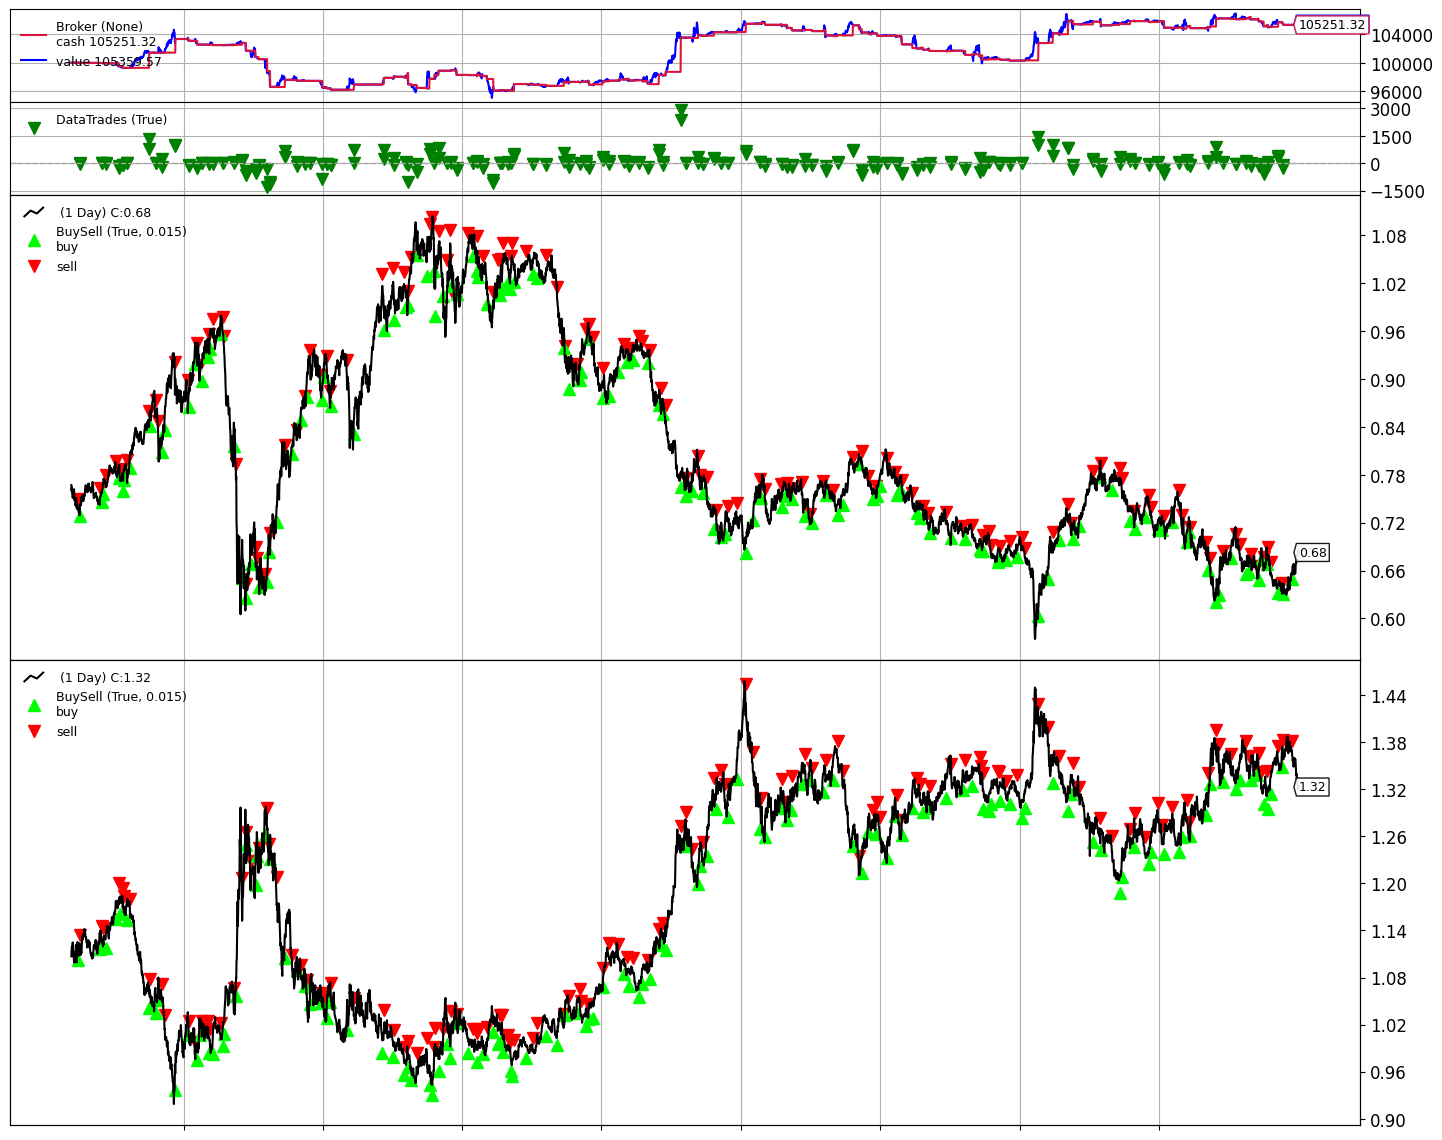

[[<Figure size 1500x1200 with 6 Axes>]]

In [228]:
# Plot the results
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)

In [229]:
print(f'Starting Portfolio Value: {initial_portfolio_value:.2f}')
print(f'Ending Portfolio Value: {final_portfolio_value:.2f}')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 105359.57


## Small analysis
- The results are not horrible, but the trading fees would definitely eat them all up